In [15]:
# Bibliothek für mehr-D Daten (speziell für NetCDF-Daten; Zeit, geografische Koordinaten, ...)
import xarray as xr
import dask

import numpy as np
from matplotlib import pyplot as plt

In [16]:
## Auswahl der Daten
# https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_ENS_001_031/services

# xr.open_dataset = Funktion, um Datensatz im NetDCF-Format öffnen
ds_ssh = xr.open_dataset(
    "/home/jovyan/my_materials/data/adt_5d.nc",
    # aktiviert Lazy-Loading mit Bibliothek Dask
    # Dask teilt Datensatz in kleinere Chunks auf, die nur bei Bedarf geladen werden in Arbeitsspeicher
    chunks="auto",
)
# Funktion von xarray.Dataset rename
ds_ssh = ds_ssh.rename_vars(adt="sea_surface_height")

ds_ssh = ds_ssh.rename({'latitude': 'lat', 'longitude': 'lon'})

# Übersicht des Datensatz wird angezeigt
ds_ssh

<xarray.Dataset> Size: 3GB
Dimensions:             (lat: 240, lon: 1440, time: 2327)
Coordinates:
  * lat                 (lat) float32 960B -89.88 -89.62 ... -30.38 -30.12
  * lon                 (lon) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * time                (time) datetime64[ns] 19kB 1993-01-01 ... 2024-11-04
Data variables:
    sea_surface_height  (time, lat, lon) float32 3GB dask.array<chunksize=(808, 83, 499), meta=np.ndarray>

In [17]:
## Filterzeitraum definieren

start_date = '1999-11-01'
end_date = '2023-12-01'

# Filter anwenden
gefilterte_ssh = ds_ssh.sel(time=slice(start_date, end_date))

# Gefilterte Daten speichern
output_path = "/home/jovyan/my_materials/data/gefilterte_ssh.nc"
gefilterte_ssh.to_netcdf(output_path)
print(f"Gefilterte SSH-Daten wurden in {output_path} gespeichert.")

gefilterte_ssh

Gefilterte SSH-Daten wurden in /home/jovyan/my_materials/data/gefilterte_ssh.nc gespeichert.


<xarray.Dataset> Size: 2GB
Dimensions:             (lat: 240, lon: 1440, time: 1760)
Coordinates:
  * lat                 (lat) float32 960B -89.88 -89.62 ... -30.38 -30.12
  * lon                 (lon) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * time                (time) datetime64[ns] 14kB 1999-11-01 ... 2023-11-30
Data variables:
    sea_surface_height  (time, lat, lon) float32 2GB dask.array<chunksize=(309, 83, 499), meta=np.ndarray>

In [18]:
## Höhenanomalie berechnen

# Zeitlicher Mittelwert
ssh_mean = ds_ssh['sea_surface_height'].mean(dim="time")
# Anomalie von SSH
ssh_anomaly = ds_ssh['sea_surface_height'] - ssh_mean

print(ssh_mean)
print(ssh_anomaly)

<xarray.DataArray 'sea_surface_height' (lat: 240, lon: 1440)> Size: 1MB
dask.array<mean_agg-aggregate, shape=(240, 1440), dtype=float32, chunksize=(83, 499), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 960B -89.88 -89.62 -89.38 ... -30.62 -30.38 -30.12
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
<xarray.DataArray 'sea_surface_height' (time: 2327, lat: 240, lon: 1440)> Size: 3GB
dask.array<sub, shape=(2327, 240, 1440), dtype=float32, chunksize=(808, 83, 499), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 960B -89.88 -89.62 -89.38 ... -30.62 -30.38 -30.12
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * time     (time) datetime64[ns] 19kB 1993-01-01 1993-01-06 ... 2024-11-04


In [19]:
## Horizontale Ableitung für geostrophische Geschwindigkeiten

# Umbennen der Dimension
# ds_ssh = ds_ssh.rename({'latitude': 'lat', 'longitude': 'lon'})

# Schwerebeschleunigung und Coriolisparameter definieren
g = 9.81  # m/s²
f_coriolis = 2 * 7.2921e-5 * np.sin(np.radians(ds_ssh.lat))  # f = 2 * Omega * sin(lat)

# Symmetrische Ableitung (finite differences) für Gradient der SSH-Anomalie
# Abstand in m (abhängig von Breite) (dy in NS-Richtung, dx in OW-Richtung), Entfernung 2 Breitengrade ist const ~111km, Längengrade abhängig von Breite
dy, dx = 111e3, 111e3 * np.cos(np.radians(ds_ssh.lat))
# mit .differentiate Gradient berechnen und /dx und /dy für Konventierung pro Grad in pro Meter
ssh_anomaly_dx = ssh_anomaly.differentiate(coord='lon') / dx
ssh_anomaly_dy = ssh_anomaly.differentiate(coord='lat') / dy

# Geostrophische Geschwindigkeitsanomalien berechnen
u_anomaly = -(g / f_coriolis) * ssh_anomaly_dy # Dimensionen = ('latitude', 'time', 'longitude')
v_anomaly = (g / f_coriolis) * ssh_anomaly_dx # Dimensionen = ('latitude', 'time', 'longitude')

# print(v_anomaly.dims)

('lat', 'lon')


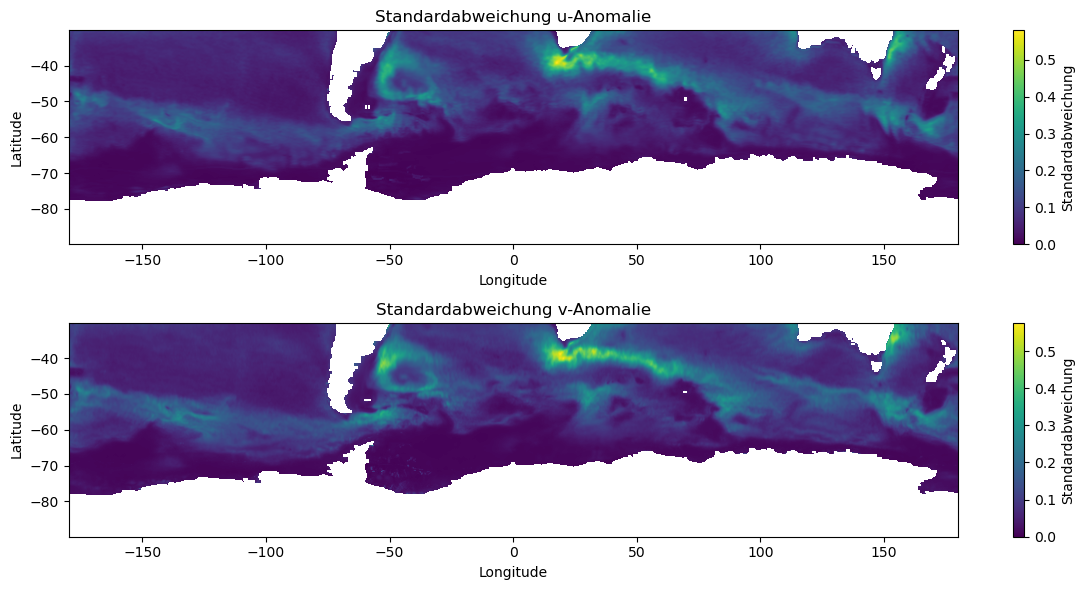

<xarray.DataArray ()> Size: 1B
array(True)
<xarray.DataArray ()> Size: 1B
array(True)


In [6]:
## zeitliche Standardabweichung der u und v Anomalie mit linearer Skala plotten
# -> hohe Std = hohe Variabilität (zb. intensive Wirbelbildung)

# Std berechnen = wie stark sie um Mittelwert streuen an jeder räumlichen Position
u_std = np.std(u_anomaly, axis=1) # über 1. Achse der Dimension durchführen -> Zeit, dh wie stark Anomalie an jeder räumlichen Position (Breite/Länge) im Zeitverlauf variieren, dh jz nur noch 2 Dim übrig -> lat und lon
v_std = np.std(v_anomaly, axis=1)

print(u_std.dims)

# Extrahieren der Koordinaten aus dem Dataset
lat = ds_ssh['lat'].values  # Wandelt die xarray-Koordinate in ein Numpy-Array um
lon = ds_ssh['lon'].values

# Plot der Standardabweichung mit linearer Skala
plt.figure(figsize=(12, 6))
# u-Anomalie Plot
plt.subplot(2, 1, 1)
plt.title('Standardabweichung u-Anomalie')
plt.imshow(u_std, origin='lower', aspect='auto', 
           extent=[lon.min(), lon.max(), lat.min(), lat.max()])
plt.colorbar(label='Standardabweichung')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# v-Anomalie Plot
plt.subplot(2, 1, 2)
plt.title('Standardabweichung v-Anomalie')
plt.imshow(v_std, origin='lower', aspect='auto', 
           extent=[lon.min(), lon.max(), lat.min(), lat.max()])
plt.colorbar(label='Standardabweichung')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()

# TODO NaN-Werte sind vorhanden, daher so lange Berechenzeit? -> noch 90er teils abschneiden ODER anderer Fehler, da Satellitendaten automatisch gefüllt worden sind?
print(np.isnan(u_anomaly).any().compute())  # Überprüft auf NaN-Werte in u_anomaly
print(np.isnan(v_anomaly).any().compute())  # Überprüft auf NaN-Werte in v_anomaly

In [7]:
## EKE berechnen

eke = 0.5 * (u_anomaly**2 + v_anomaly**2)  # EKE: 1/2 * (u'^2 + v'^2)

print(eke)

<xarray.DataArray (lat: 240, time: 2327, lon: 1440)> Size: 3GB
dask.array<mul, shape=(240, 2327, 1440), dtype=float32, chunksize=(83, 808, 499), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 960B -89.88 -89.62 -89.38 ... -30.62 -30.38 -30.12
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * time     (time) datetime64[ns] 19kB 1993-01-01 1993-01-06 ... 2024-11-04


In [8]:
## Masken erstellen

# Zeitliche Maske -> Sommerzeit
summer_months = [12, 1, 2]  # Dezember bis Februar
summer_mask = ds_ssh['time.month'].isin(summer_months)

# Maske anwenden, um gültige Punkte basierend auf Sommerdaten zu extrahieren
ssh_summer = ds_ssh['sea_surface_height'].where(summer_mask)

# 3. Räumliche Maske erstellen: Gültigkeit über die Zeit aggregieren
valid_mask = ssh_summer.notnull().any(dim="time")  # Aggregation über 'time'

# 4. Maske anwenden (optional): Nur gültige Punkte behalten
ds_summer = ds_ssh.where(valid_mask)

# Dim prüfen
print("Dimensionen von summer_mask:", summer_mask.dims)  # 'time'
print("Dimensionen von valid_mask:", valid_mask.dims)    # 'lat', 'lon'

Dimensionen von summer_mask: ('time',)
Dimensionen von valid_mask: ('lat', 'lon')


In [9]:
## Gewichtung durch cos(lat) und Fläche

cos_lat = np.cos(np.radians(ds_summer['lat']))
area_weights = cos_lat * valid_mask  # Maske berücksichtigt gültige Werte (z. B. Sommer, eisfrei)

print(area_weights)
print("Dimensionen area_weights",area_weights.dims)

<xarray.DataArray (lat: 240, lon: 1440)> Size: 1MB
dask.array<multiply, shape=(240, 1440), dtype=float32, chunksize=(83, 499), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 960B -89.88 -89.62 -89.38 ... -30.62 -30.38 -30.12
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Dimensionen area_weights ('lat', 'lon')


In [10]:
## Mittelungen bzgl Gitterboxgröße

# 1. Globale gewichtete Mittelung
eke_global_mean = (eke * area_weights).sum(dim=['lat', 'lon']) / area_weights.sum(dim=['lat', 'lon'])
print("Global gewichtetes EKE (über Fläche):", eke_global_mean.values)

# 2. Räumliche Mittelung (pro Breitengrad)

# 2.1 Normierungsfaktor basierend auf cos(lat)
cos_lat_sum = (cos_lat * valid_mask).sum(dim='lat')  # Normierung entlang lat

# 2.2 Mittelung der EKE entlang der Längengrade (lon)
eke_mean_lon = eke.mean(dim='lon')  # Reduktion der Dimension 'lon'

# 2.3 Gewichtete Mittelung entlang der Breiten
eke_lat_mean = (eke_mean_lon * cos_lat).sum(dim='time') / cos_lat.sum()

# Prüfen der Dimensionen
print("Dimensionen von eke_lat_mean:", eke_lat_mean.dims)

Global gewichtetes EKE (über Fläche): [0.01352083 0.0134919  0.01354116 ... 0.01477281 0.01502583 0.01302394]
Dimensionen von eke_lat_mean: ('lat',)


In [11]:
## EKE über SO mitteln

# Südlicher Ozean: Breite -60° bis -30°
eke_southern_ocean = eke.sel(lat=slice(-60, -30)).mean(dim=['lat', 'lon'])

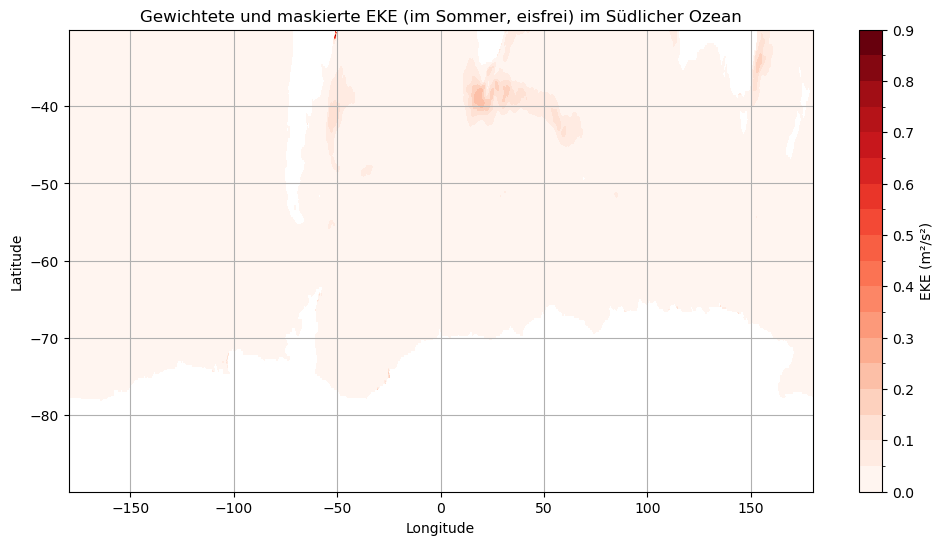

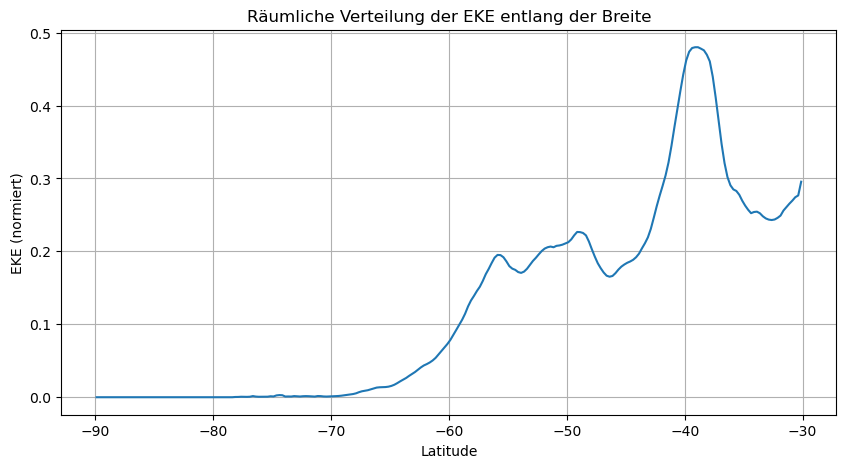

In [12]:
## EKE plotten

# Sicherstellen, dass nur über die Zeit gemittelt wird, nicht über andere Dimensionen
eke_time_mean_masked = (eke * area_weights).mean(dim='time')

plt.figure(figsize = (12, 6))
eke_time_mean_masked.plot.contourf(levels=20, cmap='Reds', cbar_kwargs={'label': 'EKE (m²/s²)'})
plt.title("Gewichtete und maskierte EKE (im Sommer, eisfrei) im Südlicher Ozean")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()
plt.show()

# Räumliche Verteilung der EKE entlang der Breite
plt.figure(figsize=(10, 5))
eke_lat_mean.plot()
plt.title("Räumliche Verteilung der EKE entlang der Breite")
plt.xlabel("Latitude")
plt.ylabel("EKE (normiert)")
plt.grid()
plt.show()

# Langfristige und regionale Variabilität der EKE
#eke_time_series = eke_southern_ocean.mean(dim=['latitude', 'longitude'])
#print(eke_time_series.dims)


#plt.figure(figsize=(12, 6))
#eke_time_series.plot()
#plt.title("Zeitliche Variabilität der Eddy Kinetischen Energie (Südlicher Ozean")
#plt.xlabel("Zeit")
#plt.ylabel("EKE (m²/s²)")
#plt.grid()
#plt.show()